# Demonstration of MUSE

This is a demonstration of MUSE analysis on a multi-modality simulated data.

Altschuler & Wu Lab 2020.

Software provided as is under MIT License.

## Import packages

In [1]:
import muse_sc as muse
import simulation_tool.multi_modal_simulation as simulation

import phenograph
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
np.random.seed(0)

## Generate simulation data

Simulation parameters

In [2]:
latent_dim = 100
num_cluster = 10
sample_size = 1000
latent_code_dim = 30
observed_data_dim = 500
sigma_1 = 0.1  
sigma_2 = 0.1  
decay_coef_1 = 0.5 
decay_coef_2 = 0.1
merge_prob = 0.7

Use simulation tool to generate multi-modality data

In [3]:
data = simulation.multi_modal_simulator(num_cluster, sample_size,
                                        observed_data_dim, observed_data_dim,
                                        latent_code_dim,
                                        sigma_1, sigma_2,
                                        decay_coef_1, decay_coef_2,
                                        merge_prob)
data_a = data['data_a_dropout']
data_b = data['data_b_dropout']
label_a = data['data_a_label']
label_b = data['data_b_label']
label_true = data['true_cluster']

## Analyses based on single modality

Learn features from single modality

In [4]:
view_a_feature = PCA(n_components=latent_dim).fit_transform(data_a)
view_b_feature = PCA(n_components=latent_dim).fit_transform(data_b)

Perform clustering using PhenoGraph

In [5]:
view_a_label, _, _ = phenograph.cluster(view_a_feature)
view_b_label, _, _ = phenograph.cluster(view_b_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.24274897575378418 seconds
Jaccard graph constructed in 0.6780366897583008 seconds
Wrote graph to binary file in 0.17591404914855957 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.5281
After 3 runs, maximum modularity is Q = 0.531725
Louvain completed 23 runs in 1.0269584655761719 seconds
PhenoGraph complete in 2.160290479660034 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3270394802093506 seconds
Jaccard graph constructed in 0.6828784942626953 seconds
Wrote graph to binary file in 0.1006464958190918 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.670447
Louvain completed 21 runs in 0.7937324047088623 seconds
PhenoGraph complete in 1.9155867099761963 seconds


## Combined analysis using MUSE

MUSE learns the joint latent representation

In [6]:
muse_feature, reconstruct_x, reconstruct_y, \
latent_x, latent_y = muse.muse_fit_predict(data_a,
                                           data_b,
                                           view_a_label,
                                           view_b_label,
                                           latent_dim=100,
                                           n_epochs=500,
                                           lambda_regul=5,
                                           lambda_super=5)

MUSE initialization
epoch: 0, 	 total loss: 1878.41858,	 reconstruction loss: 875.39502,	 sparse penalty: 200.60471
epoch: 50, 	 total loss: 1102.12756,	 reconstruction loss: 154.48811,	 sparse penalty: 189.52789
epoch: 100, 	 total loss: 1046.45496,	 reconstruction loss: 154.49231,	 sparse penalty: 178.39253
epoch: 150, 	 total loss: 992.34967,	 reconstruction loss: 154.50757,	 sparse penalty: 167.56842
epoch: 0, 	 total loss: 985.38654,	 reconstruction loss: 154.51338,	 sparse penalty: 157.10980,	 x triplet: 4.39213,	 y triplet: 4.67269
epoch: 50, 	 total loss: 922.62885,	 reconstruction loss: 154.51761,	 sparse penalty: 147.04427,	 x triplet: 3.41231,	 y triplet: 3.16568
epoch: 100, 	 total loss: 869.48053,	 reconstruction loss: 154.51697,	 sparse penalty: 137.35999,	 x triplet: 2.89788,	 y triplet: 2.73485
epoch: 150, 	 total loss: 821.07928,	 reconstruction loss: 154.51852,	 sparse penalty: 128.06015,	 x triplet: 2.57984,	 y triplet: 2.67215
Finding 30 nearest neighbors using mink

PhenoGraph clustering

In [7]:
muse_label, _, _ = phenograph.cluster(muse_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13106560707092285 seconds
Jaccard graph constructed in 1.9922587871551514 seconds
Wrote graph to binary file in 0.14496374130249023 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.898766
Louvain completed 21 runs in 1.739366054534912 seconds
PhenoGraph complete in 4.021952867507935 seconds


## Visualization of latent spaces 
Latent spaces of single-modality features or MUSE features were visualized using tSNE, with ground truth cluster labels.

Cluster accuries were quantified using adjusted Rand index (ARI). ARI = 1 indicates perfectly discover true cell identities.

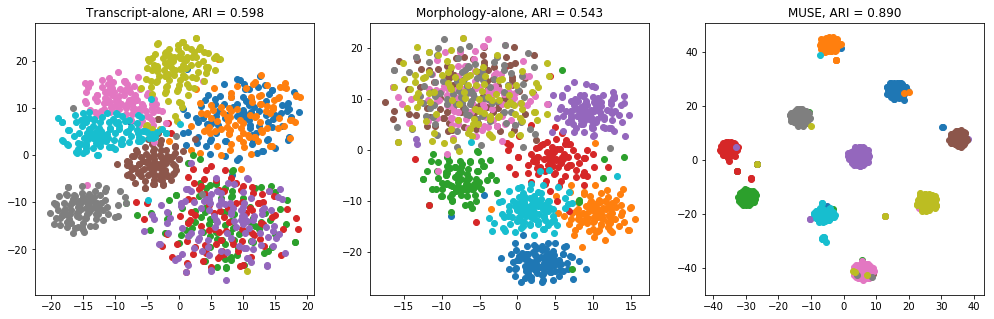

In [8]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
X_embedded = TSNE(n_components=2).fit_transform(view_a_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Transcript-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_a_label))

plt.subplot(1, 3, 2)
X_embedded = TSNE(n_components=2).fit_transform(view_b_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Morphology-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_b_label))

plt.subplot(1, 3, 3)
X_embedded = TSNE(n_components=2).fit_transform(muse_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('MUSE, ARI = %01.3f' % adjusted_rand_score(label_true, muse_label))